### 🧩 Imports

Import all the necessary libraries:
- `json` for reading/writing JSON files.
- `pandas` and `numpy` for data manipulation.
- `random` for generating random synthetic data.
- `IsolationForest` from `sklearn` for anomaly detection.
- `joblib` for saving the trained model.

In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn joblib


In [2]:
import json
import pandas as pd
from sklearn.ensemble import IsolationForest
import numpy as np
import random
import joblib

### 📊 Generate Dataset

Create synthetic "normal" network traffic data to train an anomaly detection model. Each sample includes:

- `src_port`: randomly selected from common service ports.
- `dst_port`: a random high port number.
- `packet_size`: typical packet sizes.
- `duration_ms`: duration of the communication.
- `protocol`: randomly selected between TCP and UDP.

This data is saved to `training_data.json` for future use.

In [3]:
# ساخت دیتاست مصنوعی نرمال برای آموزش مدل

def generate_normal_data(n_samples=1000):
    random.seed(42)
    np.random.seed(42)

    # داده‌های نرمال با توزیع گوسین
    feature_1 = np.random.normal(loc=0, scale=1, size=n_samples)
    feature_2 = np.random.normal(loc=5, scale=1.5, size=n_samples)
    feature_3 = np.random.normal(loc=-3, scale=0.5, size=n_samples)

    data = pd.DataFrame({
        'feature_1': feature_1,
        'feature_2': feature_2,
        'feature_3': feature_3
    })

    return data

# تولید داده
normal_data = generate_normal_data()
normal_data.head()


,feature_1,feature_2,feature_3
0,0.496714,7.099033,-3.337589
1,-0.138264,6.386951,-3.072259
2,0.647689,5.089446,-3.396210
3,1.523030,4.029595,-3.153981
4,-0.234153,6.047335,-3.946807


In [5]:
# ساخت مدل با الگوریتم Isolation Forest
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# آموزش مدل روی داده‌های نرمال
model.fit(normal_data)

# ذخیره مدل آموزش دیده در فایل
joblib.dump(model, 'isolation_forest_model.joblib')

print("✅ مدل آموزش داده شد و ذخیره شد.")


✅ مدل آموزش داده شد و ذخیره شد.


In [6]:
!ls -l isolation_forest_model.joblib


-rw-r--r-- 1 root root 1168665 Jun 12 12:41 isolation_forest_model.joblib


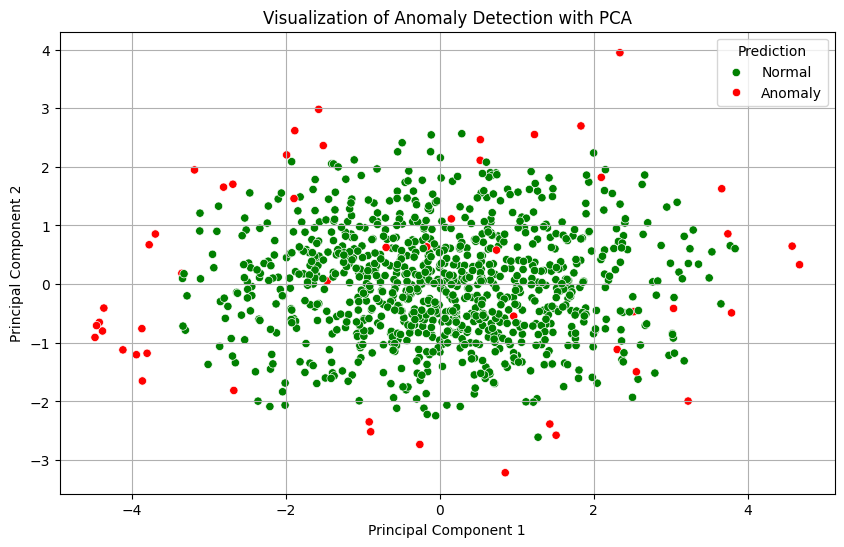

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# کاهش بعد داده‌ها از 3 بعدی به 2 بعدی برای رسم نمودار
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normal_data)

# پیش‌بینی مدل: 1 = نرمال، -1 = ناهنجار
predictions = model.predict(normal_data)

# ساخت دیتافریم برای رسم نمودار
plot_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
plot_df['Anomaly'] = predictions

# تنظیم رنگ‌ها: ناهنجار = قرمز، نرمال = سبز
palette = {1: 'green', -1: 'red'}

# رسم نمودار
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Anomaly', palette=palette)
plt.title('Visualization of Anomaly Detection with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Prediction', labels=['Normal', 'Anomaly'])
plt.grid(True)
plt.show()


In [7]:
COMMON_PORTS = [80, 443, 22, 8080]

def generate_normal_data():
    return {
        "src_port": random.choice(COMMON_PORTS),
        "dst_port": random.randint(1024, 65535),
        "packet_size": random.randint(100, 1500),
        "duration_ms": random.randint(50, 500),
        "protocol": random.choice(["TCP", "UDP"])
    }

dataset = [generate_normal_data() for _ in range(1000)]

with open("../dataset/training_data.json", "w") as f:
    json.dump(dataset, f, indent=2)


FileNotFoundError: [Errno 2] No such file or directory: '../dataset/training_data.json'

In [ ]:
with open("./dataset/training_data.json") as f:
    raw_data = json.load(f)

df = pd.DataFrame(raw_data)
display(df)

### 🧼 Preprocessing Function

Machine learning models like Isolation Forest require **numerical input only**. Any categorical variables, such as the `protocol` column (`TCP`, `UDP`), must be converted into numbers.

We handle this with **one-hot encoding**, using `pd.get_dummies`.

#### 🛠️ Preprocessing Steps:

1. **Identify categorical columns**:
   - In our case, the `protocol` column is categorical (`TCP`, `UDP`).

2. **Use `pd.get_dummies`**:
   - This creates a new binary column for each category.
   - For instance:
     ```
     protocol
     ---------
     TCP   →   protocol_UDP = 0
     UDP   →   protocol_UDP = 1
     ```
   - Setting `drop_first=True` prevents multicollinearity by dropping the first category (`TCP` here), as it can be inferred from the others.

3. **Return a DataFrame with all numerical values**:
   - This is ready for model input.

> ✅ This preprocessing is essential to avoid errors during training and ensure the model can learn from categorical variables.

In [ ]:
def preprocess_data(df):
    #TODO 1: Implement preprocessing steps
    return np.array(df)

### 🤖 Train Isolation Forest

The `IsolationForest` algorithm is an unsupervised model used to detect anomalies. It isolates observations by randomly selecting features and splitting values.

- `n_estimators=100`: number of trees in the forest.
- `contamination=0.01`: assumes 1% of the data is anomalous.
- `random_state=42`: ensures reproducibility.

The model is trained on the preprocessed numerical dataset.

In [ ]:
model = IsolationForest(contamination=0.1, random_state=42)
model.fit()

### 💾 Save Trained Model

Save the trained model using `joblib`, which allows for efficient serialization and deserialization. This saved model can be reused later for inference or deployment.


In [ ]:
joblib.dump(model, "anomaly_model.joblib")

# predict data

In [ ]:
model.predict()